In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline

In [2]:
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

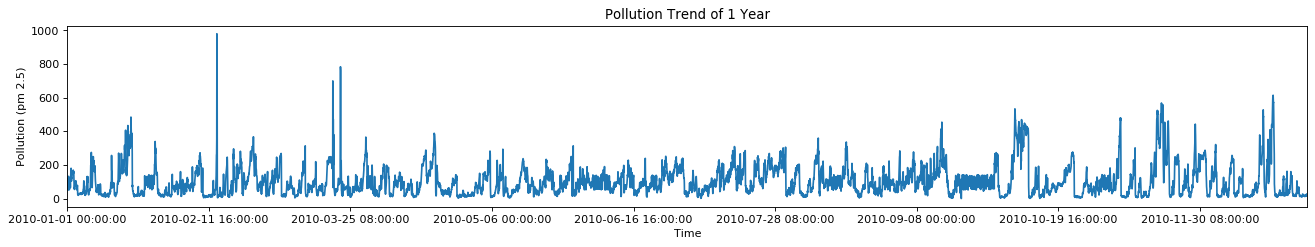

In [3]:
dataset = pd.read_csv('pollution.csv',index_col='date')
fig=plt.figure(figsize=(20, 3), dpi= 80, facecolor='w', edgecolor='k')
dataset['pollution'][:365*24].plot()
plt.title('Pollution Trend of 1 Year')
plt.xlabel('Time')
plt.ylabel('Pollution (pm 2.5)')
plt.show()

In [5]:
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,month
date,,,,,,,,,
2010-01-01 00:00:00,72.0,-21,-11.0,1021.0,NW,1.79,0,0,1
2010-01-01 01:00:00,95.0,-21,-12.0,1020.0,NW,4.92,0,0,1
2010-01-01 02:00:00,53.0,-21,-11.0,1019.0,NW,6.71,0,0,1
2010-01-01 03:00:00,99.0,-21,-14.0,1019.0,NW,9.84,0,0,1
2010-01-01 04:00:00,118.0,-20,-12.0,1018.0,NW,12.97,0,0,1
...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0,12
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0,12
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0,12


In [4]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
#Label Encoder
lbe = LabelEncoder()
#One hot encoder for the wind direction
ohe = OneHotEncoder(categories=[4])
ohe = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [4])],
    remainder='passthrough'
)
ohe_month = OneHotEncoder(categories=[10])
ohe_month = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [10])],
    remainder='passthrough'
)
pol_scaler = MinMaxScaler()
wea_scaler = MinMaxScaler()

In [49]:
import cv2

In [50]:
class Channel_value:
    val = -1.0
    intensity = -1.0

def find_intensity_of_atmospheric_light(img, gray):
    top_num = int(img.shape[0] * img.shape[1] * 0.001)
    toplist = [Channel_value()] * top_num
    dark_channel = find_dark_channel(img)

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            val = img.item(y, x, dark_channel)
            intensity = gray.item(y, x)
            for t in toplist:
                if t.val < val or (t.val == val and t.intensity < intensity):
                    t.val = val
                    t.intensity = intensity
                    break

    max_channel = Channel_value()
    for t in toplist:
        if t.intensity > max_channel.intensity:
            max_channel = t

    return max_channel.intensity


def find_dark_channel(img):
    return np.unravel_index(np.argmin(img), img.shape)[2]


def clamp(minimum, x, maximum):
    return max(minimum, min(x, maximum))

In [9]:
import os

In [10]:
ltt=os.listdir("Beijing")

In [51]:
np.seterr(divide = 'ignore')
def get_entropy(gray,light_intensity):
    pi=0
    for i in range(1,light_intensity+1):
        p = (gray==i).sum()/gray.size
        pi-= p*max(-20,np.log2(p))
    return pi

In [83]:
import sys
sys.path.append("../dnn_from_scratch")

In [67]:
def gen_dfl(ltt):
    dfl=[]
    for i in range(len(ltt)):
        sys.stderr.write("\r{}/{}".format(i,len(ltt)))
        print("\r{}/{}".format(i,len(ltt)),end="")
        img=cv2.imread("Beijing/"+ltt[i])
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        light_intensity = gray.max()#find_intensity_of_atmospheric_light(img, gray)
        rmscontr=gray.std()
        entr=get_entropy(gray,light_intensity)
        bll=img[:,:,2].mean()
        tm=int(ltt[i][-8:-6])
        mn=int(ltt[i][-6:-4])
        if mn>=30:
            adm=1
        else:
            adm=0
        dfl.append(np.hstack((dataset.iloc[-24*365+i*24+12+tm+adm].values[:-1],np.asarray([rmscontr,entr,bll]))))
    dfl=np.asarray(dfl)
    return dfl

In [68]:
from multiprocessing import Process, Pool

In [70]:
mul=len(ltt)//4+1
pols=Pool().starmap(gen_dfl, [(ltt[i*mul:(i+1)*mul],) for i in range(4)])

In [422]:
dfdt=pd.DataFrame(np.vstack(pols))
dfdt

,0,1,2,3,4,5,6,7,8,9,10
0,43,-16,9,1016,SE,1.79,0,0,62.8937,7.50308,141.887
1,239,-8,0,1017,cv,9.36,0,0,61.9555,7.20637,139.161
2,46,-17,3,1024,cv,1.34,0,0,52.0846,7.00671,146.581
3,221,-8,-3,1021,NW,8.5,0,0,54.7054,7.02694,142.97
4,54,-12,-1,1025,cv,0.89,0,0,56.8386,7.30676,130.73
...,...,...,...,...,...,...,...,...,...,...,...
322,61,-9,10,1022,SE,59.45,0,0,54.0367,6.50628,143.965
323,20,-4,11,1024,NW,8.94,0,0,56.9551,7.34771,159.026
324,18,-14,12,1024,cv,1.78,0,0,51.1679,7.25887,154.773
325,49,-14,14,1016,SE,25.92,0,0,55.3242,7.54275,154.687


In [423]:
# dfdt=pd.DataFrame(dataset.values[:,:-1])
# dfdt

In [424]:
dfdt[4] = lbe.fit_transform(dfdt[4])

In [425]:
ndfdt= pd.DataFrame(ohe.fit_transform(dfdt)[:,1:])

In [426]:
pollution_data=np.array(dfdt.iloc[:,0])
pollution_data =pol_scaler.fit_transform(pollution_data.reshape(-1,1)).astype(np.float32)

In [427]:
weather_data=np.array(dfdt.drop(0,axis=1))
weather_data = wea_scaler.fit_transform(weather_data).astype(np.float32)

In [428]:
weather_data.shape,pollution_data.shape

((327, 10), (327, 1))

In [468]:
from tensorflow.keras.models import Sequential,model_from_json
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [469]:
model=Sequential()
model.add(Dense(512,activation='relu', input_shape=(len(weather_data[0]),)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [470]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [463]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [406]:
from nnet.network import Sequential
from nnet.layers import dense,dropout,BatchNormalization
from nnet import functions
from nnet import optimizers

In [429]:
model=Sequential()
model.add(dense(512,activation=functions.relu, input_shape=(len(weather_data[0]))))
model.add(BatchNormalization())
model.add(dropout(0.4))
model.add(dense(256,activation=functions.relu))
model.add(BatchNormalization())
model.add(dropout(0.3))
model.add(dense(128,activation=functions.relu))
model.add(BatchNormalization())
model.add(dropout(0.2))
model.add(dense(64,activation=functions.relu))
model.add(BatchNormalization())
model.add(dropout(0.1))
model.add(dense(1,activation=functions.sigmoid))

In [430]:
model.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 10)                 echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 512)                relu             5632
__________________________________________________________________________________________
2 BatchNormalization(Batc (None, 512)                echo             2048
__________________________________________________________________________________________
3 dropout(dropout)        (None, 512)                echo             0
__________________________________________________________________________________________
4 dense(dense)            (None, 256)                relu             131328
__________________________________________________________________________________________
5 Bat

In [432]:
model.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error)

In [433]:
idxs=np.arange(len(pollution_data))
np.random.shuffle(idxs)

In [434]:
weather_data=weather_data[idxs]
pollution_data=pollution_data[idxs]

In [435]:
cut=300
XDB=weather_data[:cut]
YDB=pollution_data[:cut]
XTB=weather_data[cut:]
YTB=pollution_data[cut:]

In [477]:
model.fit(XDB,YDB,batch_size=16,epochs=50,validation_data=(XTB,YTB))

Train on 300 samples, validate on 27 samples
Epoch 1/50
300/300 [==============================] - 0s 335us/sample - loss: 0.0191 - accuracy: 0.0133 - val_loss: 0.0140 - val_accuracy: 0.0370
Epoch 2/50
300/300 [==============================] - 0s 316us/sample - loss: 0.0253 - accuracy: 0.0100 - val_loss: 0.0144 - val_accuracy: 0.0370
Epoch 3/50
300/300 [==============================] - 0s 399us/sample - loss: 0.0222 - accuracy: 0.0100 - val_loss: 0.0155 - val_accuracy: 0.0370
Epoch 4/50
300/300 [==============================] - 0s 340us/sample - loss: 0.0231 - accuracy: 0.0133 - val_loss: 0.0160 - val_accuracy: 0.0370
Epoch 5/50
300/300 [==============================] - 0s 325us/sample - loss: 0.0230 - accuracy: 0.0133 - val_loss: 0.0119 - val_accuracy: 0.0370
Epoch 6/50
300/300 [==============================] - 0s 315us/sample - loss: 0.0274 - accuracy: 0.0133 - val_loss: 0.0149 - val_accuracy: 0.0370
Epoch 7/50
300/300 [==============================] - 0s 372us/sample - loss: 0

In [478]:
pred=model.predict(XTB)
pred=pol_scaler.inverse_transform(pred)
lbl=pol_scaler.inverse_transform(YTB)

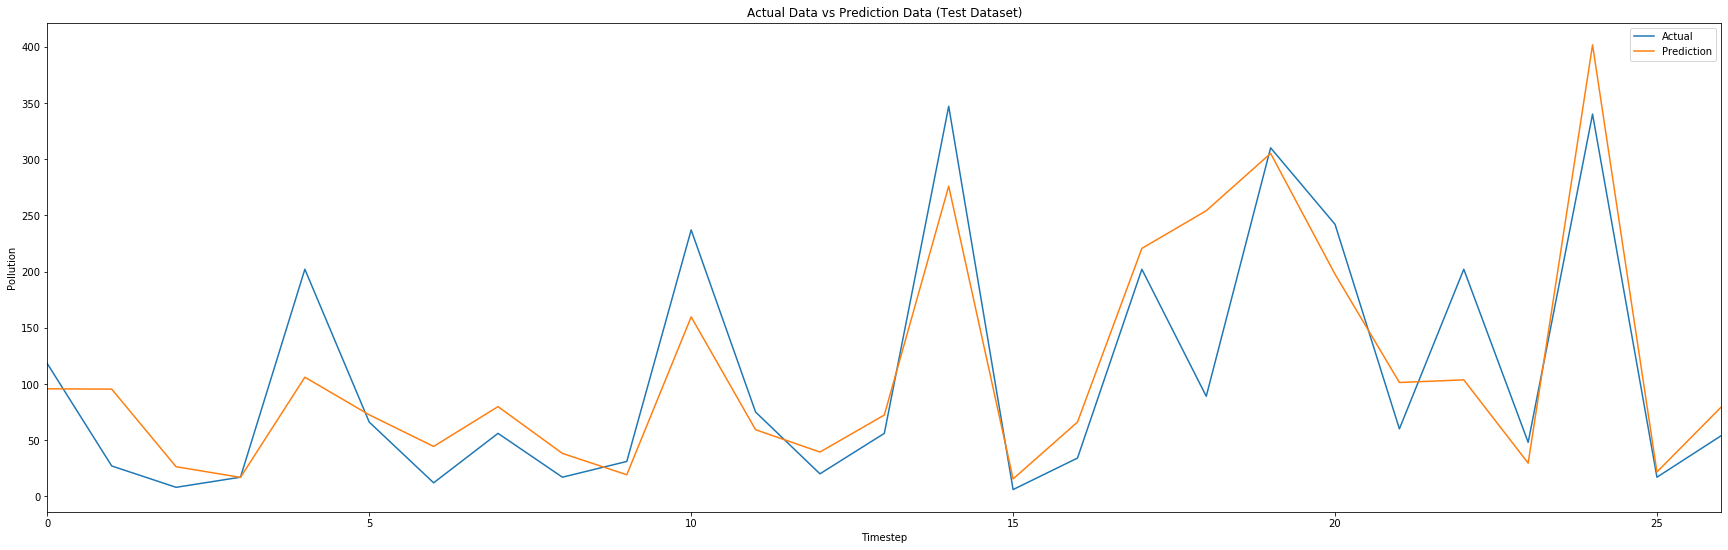

Mean Absolute Error (Test)	=	 37.96966
Root Mean Squared Error (Test)	=	 52.98860708179401
Per cent Error (Test)	=	 10.942265623241061


In [479]:
df = pd.DataFrame(np.hstack((lbl,pred)),columns=['Actual','Prediction'])
df.plot(figsize=(30,9))
plt.title("Actual Data vs Prediction Data (Test Dataset)")
plt.ylabel("Pollution")
plt.xlabel('Timestep')
plt.show()
score_mae = mean_absolute_error(lbl,pred)
score_mse = mean_squared_error(lbl,pred)
print("Mean Absolute Error (Test)\t=\t",score_mae)
print("Root Mean Squared Error (Test)\t=\t",score_mse**0.5)
print("Per cent Error (Test)\t=\t",score_mae*100/lbl.max())

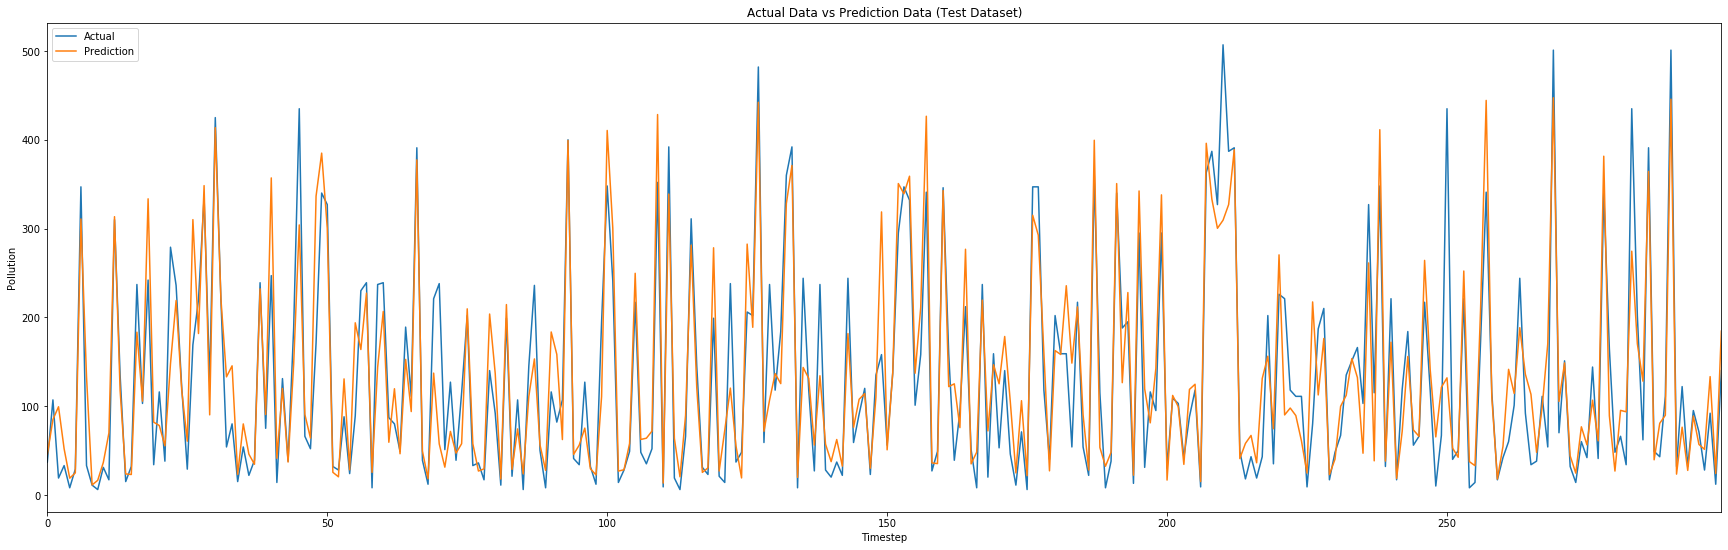

Mean Absolute Error (Test)	=	 37.270397
Root Mean Squared Error (Test)	=	 53.14066634811682
Per cent Error (Test)	=	 7.351163595596921


In [396]:
df = pd.DataFrame(np.hstack((lbl,pred)),columns=['Actual','Prediction'])
df.plot(figsize=(30,9))
plt.title("Actual Data vs Prediction Data (Test Dataset)")
plt.ylabel("Pollution")
plt.xlabel('Timestep')
plt.show()
score_mae = mean_absolute_error(lbl,pred)
score_mse = mean_squared_error(lbl,pred)
print("Mean Absolute Error (Test)\t=\t",score_mae)
print("Root Mean Squared Error (Test)\t=\t",score_mse**0.5)
print("Per cent Error (Test)\t=\t",score_mae*100/lbl.max())